In [167]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import numpy as np
import datetime
import logging

import itertools
from multiprocessing import Pool, cpu_count


In [189]:
##Logger
logging.root.handlers.clear()
logging.root.handlers

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
log_filename = f"logs/CuscoEdgesWaze1400_{timestamp}.log"

# logging.basicConfig(
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S',
# )

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')

# fileHandler = logging.FileHandler(log_filename)
# fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(logFormatter)
logger.addHandler(streamHandler)
##Logger

In [190]:
logger.info("asdas")

2023-08-17 23:40:03,166 :: INFO :: root :: 26817 :: asdas


# Mapa Cusco

In [111]:
perushape = gpd.read_file("../../Turismo/shapes/peru.shp")
perushape.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
0,01,AMAZONAS,0101,CHACHAPOYAS,010103,BALSAS,BALSAS,0001,1,INEI,"POLYGON ((-77.93289 -6.69210, -77.92945 -6.692..."
1,01,AMAZONAS,0105,LUYA,010515,PROVIDENCIA,PROVIDENCIA,0001,1,INEI,"POLYGON ((-78.29830 -6.27144, -78.29813 -6.271..."
2,01,AMAZONAS,0105,LUYA,010504,COLCAMAR,COLCAMAR,0001,1,INEI,"POLYGON ((-78.03590 -6.27044, -78.03246 -6.270..."
3,01,AMAZONAS,0106,RODRIGUEZ DE MENDOZA,010603,COCHAMAL,COCHAMAL,0001,1,INEI,"POLYGON ((-77.61592 -6.32152, -77.61650 -6.322..."
4,01,AMAZONAS,0105,LUYA,010514,PISUQUIA,YOMBLON,0001,1,INEI,"POLYGON ((-78.04105 -6.39687, -78.04115 -6.397..."


In [112]:
# cuscoshape = perushape[perushape['provincia'].isin(['CUSCO', 'QUISPICANCHI'])]
cuscoshape = perushape[perushape['provincia'].isin(['CUSCO'])]

cuscoshape.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
722,08,CUSCO,0801,CUSCO,080106,SANTIAGO,SANTIAGO,0001,1,INEI,"POLYGON ((-71.98587 -13.52254, -71.98535 -13.5..."
723,08,CUSCO,0801,CUSCO,080108,WANCHAQ,WANCHAQ,0001,1,INEI,"POLYGON ((-71.94640 -13.52731, -71.94352 -13.5..."
761,08,CUSCO,0801,CUSCO,080102,CCORCA,CCORCA,0001,1,INEI,"POLYGON ((-72.06031 -13.52861, -72.05967 -13.5..."
764,08,CUSCO,0801,CUSCO,080105,SAN SEBASTIAN,SAN SEBASTIAN,0001,1,INEI,"POLYGON ((-71.91077 -13.47772, -71.90878 -13.4..."
767,08,CUSCO,0801,CUSCO,080107,SAYLLA,SAYLLA,0001,1,INEI,"POLYGON ((-71.81245 -13.50719, -71.81173 -13.5..."


In [99]:
!ls -l data

total 61564
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 jul 31 23:23 EdgesCusco_wazeinfo.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  6769459 ago  8 21:43 GrafoCusco_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7839841 ago 12 10:45 GrafoCusco_edgeswaze0800.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7835767 ago 13 10:07 GrafoCusco_edgeswaze1400.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 ago  8 21:45 GrafoCusco_edgeswaze.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   730523 ago  8 21:43 GrafoCusco_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1086845 ago 17 22:19 GrafoCuscoTransporte_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   168885 ago 17 22:19 GrafoCuscoTransporte_nodes.csv
-rw-r--r-- 1 leibnitz.rojas hadoopgroup  5459968 ago  9 22:44 GrafoCuscoWaze.gpkg
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup 11372052 ago  9 22:29 GrafoCuscoWaze.graphml
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1694626 may 24 21:53 RutasCusco.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgro

# Loading Nodes and Edges

In [201]:
nodes = pd.read_csv("data/GrafoCuscoTransporte_nodes.csv", index_col=[0])
nodes['geometry'] = nodes['geometry'].apply(wkt.loads)
nodes = gpd.GeoDataFrame(nodes, crs='epsg:4326')
# nodes

In [212]:
edges = pd.read_csv("data/GrafoCuscoTransporte_edges.csv", index_col=[0,1,2])
edges['geometry'] = edges['geometry'].apply(wkt.loads)
edges = gpd.GeoDataFrame(edges, crs='epsg:4326')

# cond = edges['wazeinfo_km'] == -1
# edges.loc[cond,'wazeinfo_minutes'] = np.nan
# edges.loc[cond,'wazeinfo_km'] = np.nan
# edges.loc[cond,'wazeinfo'] = np.nan
cols = ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']
edges.loc[ :, cols] = edges[cols].replace({-1:np.nan})
edges.head(3)

osmid               name      highway  \
u           v          key                                              
10232315911 30970895   0    316326176  Avenida Collasuyo    secondary   
            472615572  0    316326176  Avenida Collasuyo    secondary   
10803871753 5601181487 0    586164384                NaN  residential   

                           maxspeed  oneway   length  \
u           v          key                             
10232315911 30970895   0         40   False    9.202   
            472615572  0         40   False   85.249   
10803871753 5601181487 0        NaN   False  142.060   

                                                                     geometry  \
u           v          key                                                      
10232315911 30970895   0    LINESTRING (-71.95289 -13.52105, -71.95297 -13...   
            472615572  0    LINESTRING (-71.95289 -13.52105, -71.95233 -13...   
10803871753 5601181487 0    LINESTRING (-71.98694 -13.54986, -71.98684 -13...   

                           lanes  width  ref bridge access junction  \
u           v          key                                            
10232315911 30970895   0     NaN    NaN  NaN    NaN    NaN      NaN   
            472615572  0     NaN    NaN  NaN    NaN    NaN      NaN   
10803871753 5601181487 0     NaN    NaN  NaN    NaN    NaN      NaN   

                            wazeinfo0800_minutes  wazeinfo0800_km  \
u           v          key                                          
10232315911 30970895   0                0.016667            0.008   
            472615572  0                0.200000            0.085   
10803871753 5601181487 0                0.400000            0.138   

                            wazeinfo1400_minutes  wazeinfo1400_km  
u           v          key                                         
10232315911 30970895   0                0.016667            0.008  
            472615572  0                0.200000            0.085  
10803871753 5601181487 0                0.400000            0.138

In [213]:
# edges.loc[:, cols]

In [207]:
tmp = edges[['wazeinfo0800_minutes', 'wazeinfo0800_km']].replace({-1:np.nan})
cond = tmp['wazeinfo0800_km'] == -1
# cond = edges['wazeinfo_km'].isna()
tmp.loc[cond,:]

,,,wazeinfo0800_minutes,wazeinfo0800_km
u,v,key,,


In [214]:
cond = edges['wazeinfo0800_minutes'] == -1
# cond = edges['wazeinfo_km'].isna()
edges.loc[cond,:].shape

(0, 17)

In [215]:
G = ox.graph_from_gdfs(nodes, edges)

In [110]:
amenities_gtransporte = pd.read_csv("data/AmenitiesGrafoTransporte.csv", index_col=[0])
amenities_gtransporte['geometry'] = amenities_gtransporte['geometry'].apply(wkt.loads)
amenities_gtransporte = gpd.GeoDataFrame(amenities_gtransporte, crs='epsg:4326')
amenities_gtransporte.head()

,unique_id,element_type,amenity,compressed_air,name,opening_hours,geometry_polygon,check_date,denomination,religion,...,contact:pinterest,contact:youtube,full_name,orientation,ways,type,isPoint,geometry,gtransporte_osmid,gtransporte_dist
osmid,,,,,,,,,,,,,,,,,,,,,
441195928,node/441195928,node,fuel,yes,PRIMAX,Mo-Su 00:00-12:00,POINT (-71.9124867 -13.5333168),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.91249 -13.53332),3241267614,0.000392
441195940,node/441195940,node,fuel,yes,REPSOL,Mo-Sa 00:00-12:00,POINT (-71.91688139999999 -13.5320491),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.91688 -13.53205),441195936,0.000138
444056852,node/444056852,node,toilets,NaN,NaN,NaN,POINT (-71.9893113 -13.5246483),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98931 -13.52465),444056854,0.000770
444056860,node/444056860,node,toilets,NaN,NaN,NaN,POINT (-71.9868232 -13.5267277),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98682 -13.52673),30985790,0.000541
444056873,node/444056873,node,place_of_worship,NaN,Iglesia de Nuestra Señora de Belén,NaN,POINT (-71.98132219999999 -13.5272097),2023-08-04,catholic,christian,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98132 -13.52721),30983330,0.000416


# Processing waze results for amenities

In [289]:
amenities_gtransporte['amenity'].unique()

array(['fuel', 'toilets', 'place_of_worship', 'parking', 'bus_station',
       'restaurant', 'cafe', 'marketplace', 'school', 'kindergarten',
       'fast_food', 'bank', 'pharmacy', 'atm', 'university', 'theatre',
       'townhall', 'studio', 'courthouse', 'post_office', 'dentist',
       'fountain', 'pub', 'police', 'social_facility', 'bar',
       'arts_centre', 'nightclub', 'bureau_de_change', 'veterinary',
       'car_wash', 'library', 'ice_cream', 'internet_cafe', 'planetarium',
       'waste_basket', 'bench', 'cinema', 'telephone', 'community_centre',
       'clinic', 'music_school', 'drinking_water', 'car_rental',
       'hospital', 'food_court', 'language_school', 'college',
       'nursing_home', 'childcare', 'post_box', 'doctors',
       'bicycle_parking', 'sanitary_dump_station', 'recycling',
       'events_venue', 'bicycle_rental', 'prison', 'grave_yard',
       'fire_station', 'shelter', 'motorcycle_parking', 'monastery',
       'parking_space'], dtype=object)

In [409]:
var_amenity = 'courthouse'

cond = amenities_gtransporte['amenity'] == var_amenity

nearestnodes2amenities = list(amenities_gtransporte.loc[cond,:]['gtransporte_osmid'].values)
nearestnodes2amenities = list(set(nearestnodes2amenities))
len(nearestnodes2amenities)

3

<AxesSubplot:>

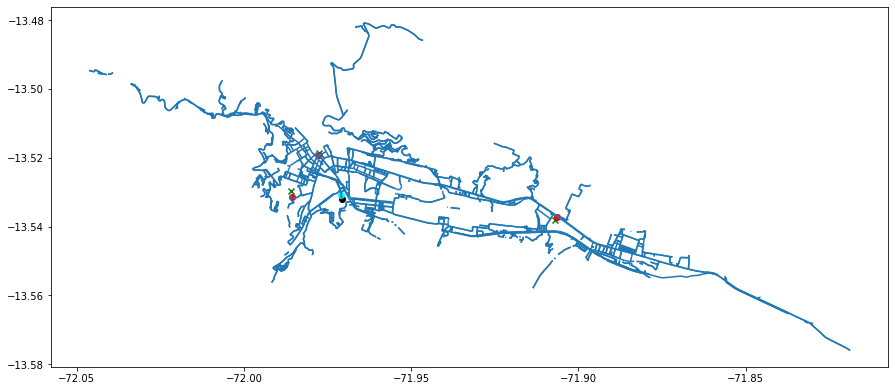

In [433]:
fig, ax = plt.subplots(figsize=(15,15))

# nodes.plot(ax=ax, color='g')
# edges.plot(ax=ax, color='yellow', alpha=0.5)
edges.plot(ax=ax)
# cuscoshape.plot(ax=ax, color='gray', alpha=0.2)
# rutascuscounique_gnodes.plot(ax=ax) 
# inputdf.plot(ax=ax, color='red')

# amenities_cols = ['unique_id', 'osmid', 'element_type', 'amenity', 'name',  'geometry',]
# amenities.loc[cond, amenities_cols ].head(2)
amenities_gtransporte.loc[cond, :].plot(ax=ax, color='green', marker='x' , )
# amenities_gtransporte.loc[[874430122], :].plot(ax=ax, color='black', )

nodes.loc[nearestnodes2amenities,:].plot(ax=ax, color='red')

# nodes.loc[nodes2plot,:].plot(ax=ax, color='red')
nodes.loc[[30965748],:].plot(ax=ax, color='black')
nodes.loc[[995446222],:].plot(ax=ax, color='cyan')
# 30965748	995446222

In [411]:
nodes.head(3)

,y,x,street_count,highway,geometry
osmid,,,,,
4427153413,-13.552679,-71.876854,2,NaN,POINT (-71.87685 -13.55268)
10232315911,-13.521048,-71.952889,3,NaN,POINT (-71.95289 -13.52105)
10803871753,-13.549859,-71.986936,1,NaN,POINT (-71.98694 -13.54986)


In [412]:
nodes_source = list(set(nodes.index))
print(len(nodes_source))
nodes_target = nearestnodes2amenities
print(len(nodes_target))

2363
3


In [413]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))

In [414]:
def shortest_path_transporte(G, node_source, node_target):
    try:
        resdict = {}
        for w in ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']:
            res = nx.shortest_path_length(G, 
                                      source=node_source, 
                                      target=node_target, 
                                      weight=w)
            resdict[w] = res
    except Exception as e:
        resdict = {}
    return resdict    

In [415]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,4427153413,441230275
1,4427153413,3738278157
2,4427153413,30985399


In [416]:
# shortest_path_transporte(G, 30965748, 30985592 )

In [417]:
# %%time
# nodes_sourcecrosstarget_df.head(20).apply(lambda x: shortest_path_transporte(G, x.source, x.target), axis=1 )

In [418]:
nodes_sourcecrosstarget_df.shape[0] , nodes_sourcecrosstarget_df.shape[0]/40

(7089, 177.225)

In [419]:
%%time
def process_row(row):
    result = shortest_path_transporte(G, row.source, row.target)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 1000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 8


2023-08-29 20:48:36,330 :: INFO :: root :: 26817 :: Multiprocessing started.
2023-08-29 20:49:03,227 :: INFO :: root :: 26817 :: Multiprocessing completed.


CPU times: user 50.3 ms, sys: 235 ms, total: 285 ms
Wall time: 27.2 s


In [420]:
len(results)

8

In [421]:
results_df = pd.DataFrame(pd.concat(results), columns=['dict'])
results_df

,dict
0,{}
1,{}
2,{}
3,"{'wazeinfo0800_minutes': 7.099999999999999, 'w..."
4,"{'wazeinfo0800_minutes': 3.9499999999999993, '..."
...,...
7084,"{'wazeinfo0800_minutes': 12.966666666666672, '..."
7085,{}
7086,"{'wazeinfo0800_minutes': 11.200000000000005, '..."
7087,"{'wazeinfo0800_minutes': 5.6, 'wazeinfo0800_km..."


In [422]:
df = nodes_sourcecrosstarget_df.merge(results_df, how='left', left_index=True, right_index=True)
df

,source,target,dict
0,4427153413,441230275,{}
1,4427153413,3738278157,{}
2,4427153413,30985399,{}
3,10232315911,441230275,"{'wazeinfo0800_minutes': 7.099999999999999, 'w..."
4,10232315911,3738278157,"{'wazeinfo0800_minutes': 3.9499999999999993, '..."
...,...,...,...
7084,588513256,3738278157,"{'wazeinfo0800_minutes': 12.966666666666672, '..."
7085,588513256,30985399,{}
7086,30965748,441230275,"{'wazeinfo0800_minutes': 11.200000000000005, '..."
7087,30965748,3738278157,"{'wazeinfo0800_minutes': 5.6, 'wazeinfo0800_km..."


In [423]:
%%time
# Create an empty DataFrame with columns as unique keys from all dictionaries
columns = set().union(*(d.keys() for d in df['dict'] if d))
df2 = pd.DataFrame(columns=columns)
df2

CPU times: user 9.15 ms, sys: 11 µs, total: 9.16 ms
Wall time: 8.93 ms


,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,wazeinfo0800_minutes


In [424]:
%%time
# Iterate through each row's dictionary and populate the result DataFrame
for idx, row in df.iterrows():
    df2.loc[idx] = row['dict']

CPU times: user 30.9 s, sys: 27.8 ms, total: 30.9 s
Wall time: 30.9 s


In [425]:
# %%time
# # Create an empty DataFrame with columns as unique keys from all dictionaries
# columns = set().union(*(d.keys() for d in df['dict'] if d))
# df2 = pd.DataFrame(columns=columns)
# # df2
# # Function to process each row
# def process_row(idx, row_dict):
#     df2.loc[idx] = row_dict

# # Create a pool of worker processes
# num_processes = cpu_count()  # You can adjust the number of processes
# pool = Pool(processes=num_processes)

# # Use the pool to process rows in parallel
# for idx, row_dict in df['dict'].iteritems():
#     pool.apply_async(process_row, args=(idx, row_dict))

# # Close the pool and wait for all processes to finish
# pool.close()
# pool.join()

In [426]:
df2

,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,wazeinfo0800_minutes
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,2.200,6.200000,2.200,7.100000
4,1.613,3.783333,1.613,3.950000
...,...,...,...,...
7084,5.857,12.600000,5.856,12.966667
7085,NaN,NaN,NaN,NaN
7086,4.651,11.216667,4.651,11.200000
7087,1.178,5.100000,1.178,5.600000


In [427]:
# df.merge(df2, )
df3 = df[['source', 'target']].merge(df2, how='left', left_index=True, right_index=True)
df3

,source,target,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,wazeinfo0800_minutes
0,4427153413,441230275,NaN,NaN,NaN,NaN
1,4427153413,3738278157,NaN,NaN,NaN,NaN
2,4427153413,30985399,NaN,NaN,NaN,NaN
3,10232315911,441230275,2.200,6.200000,2.200,7.100000
4,10232315911,3738278157,1.613,3.783333,1.613,3.950000
...,...,...,...,...,...,...
7084,588513256,3738278157,5.857,12.600000,5.856,12.966667
7085,588513256,30985399,NaN,NaN,NaN,NaN
7086,30965748,441230275,4.651,11.216667,4.651,11.200000
7087,30965748,3738278157,1.178,5.100000,1.178,5.600000


In [428]:
df3.to_csv(f"data/wazeresults_{var_amenity}.csv", sep=';', index=False)

In [429]:
!ls -l data

total 105300
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1185519 ago 17 22:26 AmenitiesGrafoTransporte.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 jul 31 23:23 EdgesCusco_wazeinfo.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  6769459 ago  8 21:43 GrafoCusco_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7839841 ago 12 10:45 GrafoCusco_edgeswaze0800.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7835767 ago 13 10:07 GrafoCusco_edgeswaze1400.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  9093449 ago 23 22:47 GrafoCusco_edgeswaze.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1824005 ago 23 22:49 GrafoCusco_edgeswaze.zip
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   730523 ago  8 21:43 GrafoCusco_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   181126 ago 23 22:50 GrafoCusco_nodes.zip
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1168706 ago 24 22:29 GrafoCuscoTransporte_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   168885 ago 24 22:28 GrafoCuscoTransporte_nodes.csv
-rw-rw-r-- 1 leibni

In [431]:
pd.read_csv(f"data/wazeresults_{var_amenity}.csv", sep=';',)

,source,target,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,wazeinfo0800_minutes
0,4427153413,441230275,NaN,NaN,NaN,NaN
1,4427153413,3738278157,NaN,NaN,NaN,NaN
2,4427153413,30985399,NaN,NaN,NaN,NaN
3,10232315911,441230275,2.200,6.200000,2.200,7.100000
4,10232315911,3738278157,1.613,3.783333,1.613,3.950000
...,...,...,...,...,...,...
7084,588513256,3738278157,5.857,12.600000,5.856,12.966667
7085,588513256,30985399,NaN,NaN,NaN,NaN
7086,30965748,441230275,4.651,11.216667,4.651,11.200000
7087,30965748,3738278157,1.178,5.100000,1.178,5.600000
